#Assignment 3:
    test if the distribution of ages can be modelled by a Gaussian
    
    1) all riders
    
    2) summer riders vs winder riders
    
    use 2 tests, you can use KS, AD, or get creative. use KL or chi2 like you did in Assignment2 or perhaps new ones!
    
    CHALLANGE! look for a better distribution to fit the data! see notes on how to input a number of different 
    distributions into the test, not just 'norm' and the few others available by keyword

my usual imports and setups

In [1]:
import csv
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats
from zipfile import ZipFile
from StringIO import StringIO
import urllib2
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I need 2 seasons, lets start reading in data from January 2015, and June 2015. 
One month is not a season. You should import data from other months in the winter as well, and then several summer months to get the other distribution. I am being lazy but you should not be. 



In [10]:
#df_W=pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201501-citibike-tripdata.csv')
#print df_W.columns
#df_S=pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201506-citibike-tripdata.csv')


Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')


In [2]:
#For Winter
ridesWin = []

# To pull csv files from host
monthsWin = ['01', '02', '03'] #to pull Jan, Feb, March
for month in monthsWin:
    urlWin = "https://s3.amazonaws.com/tripdata/2015%s-citibike-tripdata.zip" % month
    rWin = urllib2.urlopen(urlWin).read()
    fWin = ZipFile(StringIO(rWin))
    csvWin = fWin.open("2015%s-citibike-tripdata.csv" % month)
    frameWin = pd.read_csv(csvWin)
    #frameWin['ts'] = pd.to_datetime(frameWin.starttime, format = '%m/%d/%Y %H:%M:%S') #forgot we don't care about dates/ times
    ridesWin.append(frameWin)
    
# Concatenate all the individual months into one.
dfWinter = pd.concat(ridesWin, ignore_index=True)
print len(dfWinter)

824308


In [4]:
#For Summer
ridesSum = []

# To pull csv files from host
monthsSum = ['06', '07', '08'] #to pull Jun, July, Aug
for month in monthsSum:
    urlSum = "https://s3.amazonaws.com/tripdata/2015%s-citibike-tripdata.zip" % month
    rSum = urllib2.urlopen(urlSum).read()
    fSum = ZipFile(StringIO(rSum))
    csvSum = fSum.open("2015%s-citibike-tripdata.csv" % month)
    frameSum = pd.read_csv(csvSum)
    #frameSum['ts'] = pd.to_datetime(frameSum.starttime) #forgot we don't care about dates/ times
    ridesSum.append(frameSum)
    
dfSummer = pd.concat(ridesSum, ignore_index=True)
print len(dfSummer)

3205939


## get the age like we did before, subscribers only cause otherwise the ages are really sparse anyways


In [10]:
#Creating new column in each dataframe containing subscriber ages
dfWinter['age'] = 2015-dfWinter['birth year'][(dfWinter['usertype'] == 'Subscriber')]
dfSummer['age'] = 2015-dfSummer['birth year'][(dfSummer['usertype'] == 'Subscriber')]

In [11]:
#All summer and winter rides together:
allFrames = [dfWinter, dfSummer]
dfAll = pd.concat(allFrames)
print len(dfAll)

4030247


lets split age in 10 year bins. see the comment in assignment 1 about this

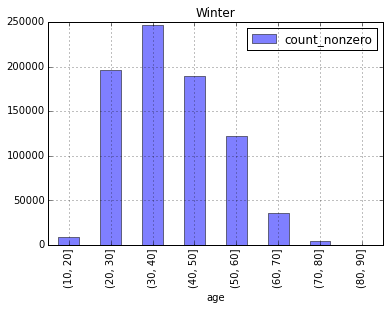

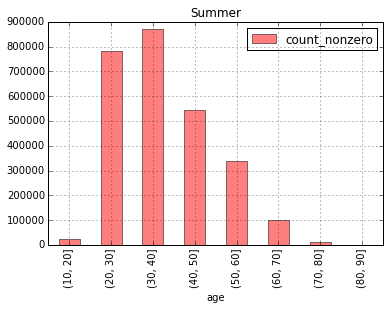

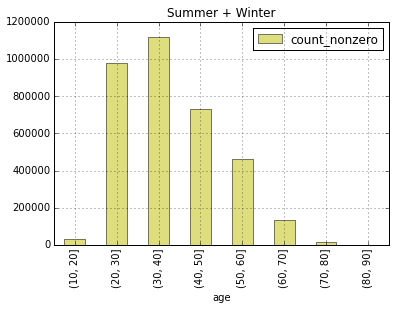

In [12]:
# for histograms
bins = np.arange(10, 99, 10)

dfWinter.age.groupby(pd.cut(dfWinter.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Winter", alpha = .5)
W_age_dist = dfWinter.age.groupby(pd.cut(dfWinter.age, bins)).agg([count_nonzero])

dfSummer.age.groupby(pd.cut(dfSummer.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Summer", alpha = .5, color = "r")
S_age_dist = dfSummer.age.groupby(pd.cut(dfSummer.age, bins)).agg([count_nonzero])

dfAll.age.groupby(pd.cut(dfAll.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Summer + Winter", alpha = .5, color = "y")
A_age_dist = dfAll.age.groupby(pd.cut(dfAll.age, bins)).agg([count_nonzero])
    

The distributions of riders by age in summer, winter and combined appear to be very similar with the caveat that the scales are different (fewer riders in winter).

#KS tests for goodness of fit

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [14]:
#compare to normal

ksW=scipy.stats.kstest(W_age_dist, 'norm')
ksS=scipy.stats.kstest(S_age_dist, 'norm')
print "KS test for winter distribution fit on normal:", ksW
print "KS test for summer distribution fit on normal:", ksS

#compare to poisson??
#cauchy

ksW=scipy.stats.kstest(W_age_dist, 'cauchy')
ksS=scipy.stats.kstest(S_age_dist, 'cauchy')
print "KS test for winter distribution fit on Cauchy:", ksW
print "KS test for summer distribution fit on Cauchy:", ksS

KS test for winter distribution fit on normal: (1.0, 0.0)
KS test for summer distribution fit on normal: (1.0, 0.0)
KS test for winter distribution fit on Cauchy: (0.99999871000078544, 0.0)
KS test for summer distribution fit on Cauchy: (0.99999963442994877, 0.0)


**Reject the null for both summer and winter against both normal and cauchy distributions because of high test statistic (1.0 and .999, respectively) and a p-value of 0 for both.**

the scipy KS test works with keywords only for scipy.stats distributions 
that take as a single argument the size of the sample, like norm and cauchy look them up to make sure I am right!
if i want to test against a distribution which takes more arguments like Poisson, which in scipy.stats takes the 
lambda parameter and the size (2 arguments) i can pass the extra arguments in arg, like i do below: 

In [14]:
ksW=scipy.stats.kstest(W_age_dist, 'gamma', args=(35,))
ksS=scipy.stats.kstest(S_age_dist, 'gamma', args=(35,))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=1.0, pvalue=0.0)
summer, normal fit KstestResult(statistic=1.0, pvalue=0.0)


or i can create my function separately, then call it: all i need to do is define a function that calls  like i am doing below. the size argument must come first, and the second argument of kstest will no longer be a string, but the function itself (what we would call a "callable")

In [15]:
def mydistribution(size, m0, m1):
    #this is a crazy dumb function, but i am trying to make a point here...
    return (np.empty_like(size)+1) * m0 **2

In [16]:
ksW=scipy.stats.kstest(W_age_dist, mydistribution, args=(35,38))
ksS=scipy.stats.kstest(S_age_dist, mydistribution, args=(35,38))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=319324425.0, pvalue=nan)
summer, normal fit KstestResult(statistic=107543975.0, pvalue=nan)


##TODO FOR YOU!

-- repeat with the AD test, and/or any other tests you wish

-- do you see differences in the sample? significant differences?

-- do you dare (and this is indeed optional but could be fun) splitting the samples by up- and down-town?

##A-D Test: Seasons vs Normal/ Exponential

In [13]:
#A-D for summer/ winter on normal
#must select "count_nonzero" otherwise receive "Data must be 1-dimensional" error 
print "A-D test for winter distribution fit on normal:", scipy.stats.anderson(W_age_dist.count_nonzero, dist='norm')
print ""
print "A-D test for summer distribution fit on normal:", scipy.stats.anderson(S_age_dist.count_nonzero, dist='norm')
print ""
print "A-D test for winter distribution fit on exponential:", scipy.stats.anderson(W_age_dist.count_nonzero, dist='expon')
print ""
print "A-D test for summer distribution fit on exponential:", scipy.stats.anderson(S_age_dist.count_nonzero, dist='expon')


A-D test for winter distribution fit on normal: (0.52157228098032249, array([ 0.519,  0.591,  0.709,  0.827,  0.984]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

A-D test for summer distribution fit on normal: (0.51294415781601543, array([ 0.519,  0.591,  0.709,  0.827,  0.984]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

A-D test for winter distribution fit on exponential: (1.5010550867349739, array([ 0.858,  1.003,  1.247,  1.494,  1.82 ]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

A-D test for summer distribution fit on exponential: (1.6838616649191742, array([ 0.858,  1.003,  1.247,  1.494,  1.82 ]), array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


**The A-D test show no evidence of the distributions of neither the winter nor summer samples resembling a normal one. However, the test indicates that both winter and summer distributions potentially resemble an exponential distribution with the test stat > 1.50 in both cases at an alpha of .05 (1.247 threshold). 

##KS Test: Seasons vs Normal/ Logistic

In [14]:
# for summer/ winter on normal
print "KS test for winter distribution fit on normal:", scipy.stats.kstest(W_age_dist,'norm')
print ""
print "KS test for summer distribution fit on normal:", scipy.stats.kstest(S_age_dist,'norm')
print ""
print "KS test for winter distribution fit on logistic:", scipy.stats.kstest(W_age_dist,'logistic')
print ""
print "KS test for summer distribution fit on logistic:", scipy.stats.kstest(S_age_dist,'logistic')

KS test for winter distribution fit on normal: (1.0, 0.0)

KS test for summer distribution fit on normal: (1.0, 0.0)

KS test for winter distribution fit on logistic: (1.0, 0.0)

KS test for summer distribution fit on logistic: (1.0, 0.0)


**The KS test indicates that neither the summer nor winter groups exhibit a normal or logistic distribution.** 

##Visualize age distribution by Uptown vs Downtown MN

In [22]:
#creating dataframe from hosted csv (in my public Dropbox folder)
urlBoro = 'https://dl.dropboxusercontent.com/u/58178372/stations.csv'
openBoro = urllib2.urlopen(urlBoro)
dfBoro = pd.read_csv(openBoro)
print dfBoro.columns

In [29]:
#joining dataframes using left join on station id
merge1 = pd.merge(dfAll, dfBoro, how = 'left', left_on = 'start station id', right_on = 'id')

In [30]:
print merge1

         tripduration           starttime            stoptime  \
0                1346       1/1/2015 0:01       1/1/2015 0:24   
1                 363       1/1/2015 0:02       1/1/2015 0:08   
2                 346       1/1/2015 0:04       1/1/2015 0:10   
3                 182       1/1/2015 0:04       1/1/2015 0:07   
4                 969       1/1/2015 0:05       1/1/2015 0:21   
5                 496       1/1/2015 0:07       1/1/2015 0:15   
6                 152       1/1/2015 0:07       1/1/2015 0:09   
7                1183       1/1/2015 0:08       1/1/2015 0:28   
8                 846       1/1/2015 0:09       1/1/2015 0:23   
9                 576       1/1/2015 0:10       1/1/2015 0:20   
10                540       1/1/2015 0:10       1/1/2015 0:19   
11                419       1/1/2015 0:11       1/1/2015 0:18   
12                751       1/1/2015 0:13       1/1/2015 0:25   
13                332       1/1/2015 0:13       1/1/2015 0:18   
14               1099    

In [37]:
#creating dataframe containing only MN records
dfMN = merge1[(merge1.county == 'New York') | (merge1.county == 'New York County')]

In [40]:
#creating dataframes for uptown and downtown. just used google maps to choose a line of lat (somewhere around 65th st)
dfMNup = dfMN[(dfMN['start station latitude'] >= 40.770676)]
dfMNdown = dfMN[(dfMN['start station latitude'] < 40.770676)]

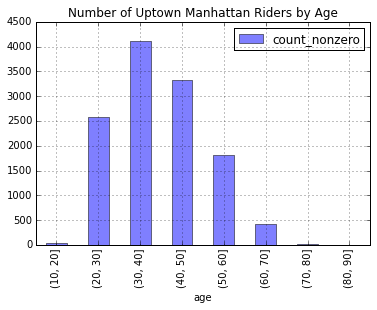

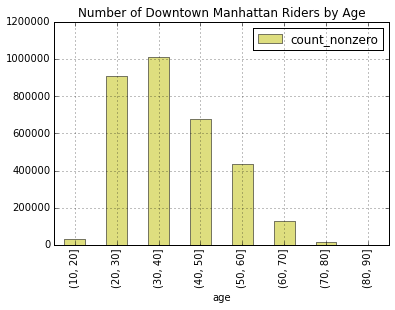

In [43]:
#for histograms
dfMNup.age.groupby(pd.cut(dfMNup.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Number of Uptown Manhattan Riders by Age", alpha = .5)
UP_age_dist = dfMNup.age.groupby(pd.cut(dfMNup.age, bins)).agg([count_nonzero])

dfMNdown.age.groupby(pd.cut(dfMNdown.age, bins)).agg([count_nonzero]).plot(kind='bar', title="Number of Downtown Manhattan Riders by Age", alpha = .5, color = 'y')
DOWN_age_dist = dfMNdown.age.groupby(pd.cut(dfMNdown.age, bins)).agg([count_nonzero])

The histograms above show that the vast majority of rides begin in lower Manhattan (below 65th street), and that the age distribution in uptown and downtown groups is similar.